In [7]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandahouse
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import poisson

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2023-07-30 по 2023-08-05 включительно. Для эксперимента были задействованы 2 и 1 группы. 

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

<b>Ваша задача — проанализировать данные А/B-теста.</b> 

 1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали именно так? 
3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [8]:
# Тянем интересующий фрейм из кликхауса прямым запросом
connection = {
    'host': 'https://clickhouse,
    'password': 'pass',
    'user': 'user',
    'database': 'db'
}

q = '''
SELECT 
user_id,
exp_group,
countIf(action, action='like') as likes,
countIf(action, action='view') as views,
countIf(action, action='like')/countIf(action, action='view') as CTR

FROM simulator_20230820.feed_actions 
WHERE 
toDate(time) >= '2023-07-30' and toDate(time) <= '2023-08-05'
AND
exp_group in (1, 2)
GROUP BY
user_id, exp_group
'''

df_users = pandahouse.read_clickhouse(q, connection=connection) 

In [9]:
# Смотрим что вытянули
df_users.head()

,user_id,exp_group,likes,views,CTR
0,109963,1,3,15,0.200000
1,26117,1,32,141,0.226950
2,138232,1,18,73,0.246575
3,18392,1,7,32,0.218750
4,26295,1,39,141,0.276596


In [24]:
# Сразу делаем большие графики
sns.set (rc={"figure.figsize":( 12 , 10 )})

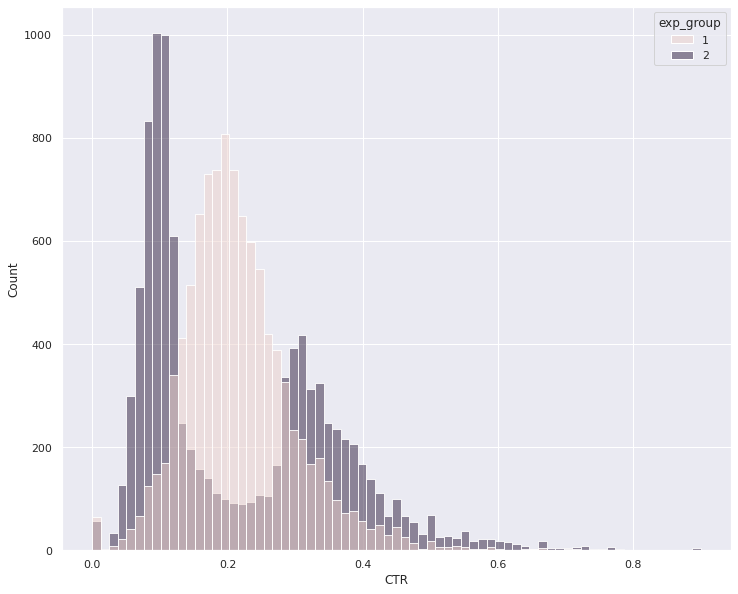

In [25]:
# Смотрим на распределения
groups = sns.histplot(data = df_users, x = 'CTR', hue='exp_group')

In [26]:
# Разделяем по группам
ctr1_control = df_users[df_users['exp_group'] == 1]
ctr1_control.name = 'control group 1'
ctr2_test = df_users[df_users['exp_group'] == 2]
ctr2_test.name = 'test group 2'

<Axes: xlabel='CTR', ylabel='Count'>

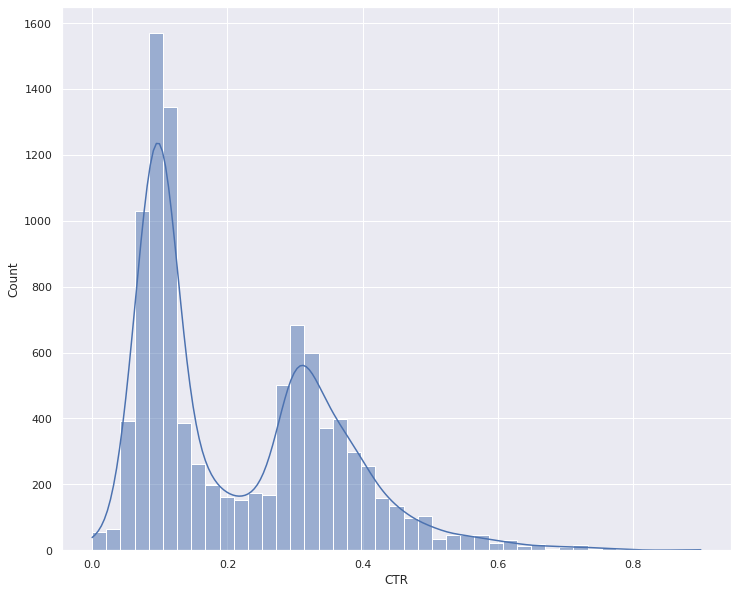

In [27]:
# Отдельно - гвоздь нашей программы =\
graph = sns.histplot(ctr2_test['CTR'], kde=True)
graph

Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).

In [28]:
# Напишем класс-пайплайн для прогона сразу всех тестов

class PipeAllTests:
    '''
    В пайплайн загружаются 2 выборки, предобработчики данных, тесты.
    Пайп прогоняет данные через обработчики и каждые обработанные данные через тесты.
    Оценивает результаты и вносит в отчет results.
    
    Порядок работы:
    1. Загружаем 2 выборки в load_data
    2. Загружаем преобразования и тесты в load_actions
    3. Запускаем расчет через fit_transform
    4. Читаем результаты через get_results
    5. Смотрим на графики обработанных выборок через view_dist_result
    '''
    
    def __init__(self):
        self.transforms = []
        self.tests = []
        self.test_group = None
        self.control_group = None
        self.test_data_processed = {}
        self.control_data_processed = {}
        self.result = {}
        
    def __repr__(self):
        # Красиво логируем
        
        return f'''Настройки пайплайна->
        Предобработка данных: {self.transforms}
        Тесты: {self.tests}
        Загружены данные: {self.test_group, self.control_group}'''
        
    def load_data(self, test_group, control_group):
        # Загружаем данные в пайп
        
        self.test_group = test_group
        self.control_group = control_group
        if self.test_group.name and self.control_group.name:
            print(f'''Загружены группы для анализа: 
            Тестовая группа: {self.test_group.name}
            Контрольная группа: {self.control_group.name}''')
    
    def load_actions(self, transforms, tests):
        # Загружаем обраотчики и тесты
        
        self.transforms = transforms
        self.tests = tests
        if self.transforms:
            print(f'''Загружены функции обработки данных:
            {self.transforms}
            Тесты оценки:
            {self.tests}
            ''')
    
    def fit_transform(self):
        # Заводим шарманку, наслаждаемся логированием=\
        
        # Преобразуем сохраняем данные
        for action in self.transforms:
            print(f'Преобразование {action}', end='  <--  ')
            start = time.time()
            if action:
                self.test_data_processed[f'{action}'] = action(self.test_group)['CTR'].copy()
                self.control_data_processed[f'{action}'] = action(self.control_group)['CTR'].copy()
            else:
                self.test_data_processed[f'{action}'] = self.test_group['CTR'].copy()
                self.control_data_processed[f'{action}'] = self.control_group['CTR'].copy()
            time_sec = round(time.time() - start, 2)
            print(f'Выполнено за {time_sec if time_sec < 60 else time_sec//60}{"" if time_sec < 60 else " min "}{time_sec % 60 if time_sec > 60 else ""} sec')
        
        # Тестируем полученные выборки и пишем данные в отчет
        print(f'Провожу тесты', end='  <--  ')
        start = time.time()
        for test in self.tests:
            for test_step, control_step in zip(self.test_data_processed, self.control_data_processed):
                self.result[f'{test_step} + {str(test).split()[1]}'] = test(self.test_data_processed[test_step], self.control_data_processed[test_step])
        time_sec = round(time.time() - start, 2)
        print(f'Выполнено за {time_sec if time_sec < 60 else time_sec//60}{"" if time_sec < 60 else " min "}{time_sec % 60 if time_sec > 60 else ""} sec')
            
    def get_results(self):
        # Получаем отчет в виде фрейма
        
        return pd.DataFrame(self.result, index=['statistic', 'p-value']).T
    
    def view_dist_result(self):
        # Смотрим на гистограммы после обработчика
        
        for a, b in zip(self.test_data_processed, self.control_data_processed):
            graph1 = self.test_data_processed[a]
            graph1.name = 'Test'
            graph2 = self.control_data_processed[b]
            graph2.name = 'Control'
            joined = pd.concat([graph1, graph2], axis=1)
            sns.histplot(joined).set(title=f'Распределение при обработке {a}')
            plt.show()

----------

<h3> Cглаживание Лапласа </h3>

In [29]:
# Напишем класс для расчета сглаженного CTR - немного измененная функция из конспекта в виде класса для логов
class SmoothCTR:
    def __init__(self, alpha=5):
        self.alpha = alpha
        
    def __repr__(self):
        return f'SmoothCTR (alpha={self.alpha})'
    
    def __call__(self, data):
        data = data.copy()
        data['CTR'] = self.get_smoothed_ctr(data.likes, data.views, self.alpha)
        return data
    
    @staticmethod
    def get_smoothed_ctr(user_likes, user_views, alpha):
        global_ctr = sum(user_likes) / sum(user_views)
        smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
        return smothed_ctr

---------------

<h3> Bootstrap </h3>

In [30]:
# Напишем класс для Bootstrap преобразования - тоже немного измененная функция из конспекта в виде класса для логов
class MyBootstrap:
    def __init__(self, n_bootstrap=10000):
        self.n_bootstrap = n_bootstrap
        
    def __repr__(self):
        return f'Bootstrap (n_bootstrap={self.n_bootstrap})'
    
    def __call__(self, data):
        data = data.copy()
        return pd.DataFrame(self.bootstrap(data.likes, data.views, self.n_bootstrap), columns=['CTR'])
    
    @staticmethod
    def bootstrap(likes, views, n_bootstrap):
        poisson_bootstraps = poisson(1).rvs((n_bootstrap, len(likes.to_numpy()))).astype(np.int64)
        globalCTR = (poisson_bootstraps*likes.to_numpy()).sum(axis=1)/(poisson_bootstraps*views.to_numpy()).sum(axis=1)
        return globalCTR

-----------------------

<h3> Backet преобразование </h3>

In [31]:
# В конспекте на питоне функцию для бакета не писали, поэтому реализую сам

class MyBacket:
    def __init__(self, n_backets=50):
        self.n_backets = n_backets
        
    def __repr__(self):
        return f'Backet (n_backets={self.n_backets})'
    
    def __call__(self, data):
        data = data.copy()
        return self.backet(data, self.n_backets)
    
    @staticmethod
    def backet(data, n_backets):
        data = data.copy()
        data['backet'] = data.user_id.map(lambda x: hash(x) % n_backets)
        backet_data = data.groupby('backet').agg({'CTR':'mean'}).reset_index()
        return backet_data

_________

<h3> Запускаем</h3>

In [32]:
# создаем объект пайплайна
test_this = PipeAllTests()

# создаем объект для преобразования сглаженного CTR(по умолчанию альфа = 5)
smoth_me = SmoothCTR()

# создаем объект для преобразования Bootstrap (по умолчанию 10000 итераций)
Bootstrap_me = MyBootstrap()

# создаем объект для преобразования Backet (по умолчанию 50 бакетов)
Backet_me = MyBacket()

In [33]:
# Грузим данные в пайп

test_this.load_data(ctr2_test, ctr1_control)

Загружены группы для анализа: 
            Тестовая группа: test group 2
            Контрольная группа: control group 1


In [34]:
# Грузим обработчики и тесты в пайп

test_this.load_actions([None, smoth_me, Bootstrap_me, Backet_me], [ttest_ind, mannwhitneyu])

Загружены функции обработки данных:
            [None, SmoothCTR (alpha=5), Bootstrap (n_bootstrap=10000), Backet (n_backets=50)]
            Тесты оценки:
            [<function ttest_ind at 0x7f4d48fee940>, <function mannwhitneyu at 0x7f4d48dbb4c0>]
            


In [35]:
# Запускаем обработку

test_this.fit_transform()

Преобразование None  <--  Выполнено за 0.0 sec
Преобразование SmoothCTR (alpha=5)  <--  Выполнено за 0.01 sec
Преобразование Bootstrap (n_bootstrap=10000)  <--  Выполнено за 25.25 sec
Преобразование Backet (n_backets=50)  <--  Выполнено за 0.03 sec
Провожу тесты  <--  Выполнено за 0.12 sec


In [36]:
# Смотрим отчет

test_this.get_results()

,statistic,p-value
None + ttest_ind,-4.065950e-01,6.843099e-01
SmoothCTR (alpha=5) + ttest_ind,-1.953248e+00,5.080419e-02
Bootstrap (n_bootstrap=10000) + ttest_ind,-5.985476e+02,0.000000e+00
Backet (n_backets=50) + ttest_ind,-4.508068e-01,6.531246e-01
None + mannwhitneyu,4.377763e+07,4.632206e-45
SmoothCTR (alpha=5) + mannwhitneyu,4.343919e+07,2.396534e-50
Bootstrap (n_bootstrap=10000) + mannwhitneyu,0.000000e+00,0.000000e+00
Backet (n_backets=50) + mannwhitneyu,1.170000e+03,5.836516e-01


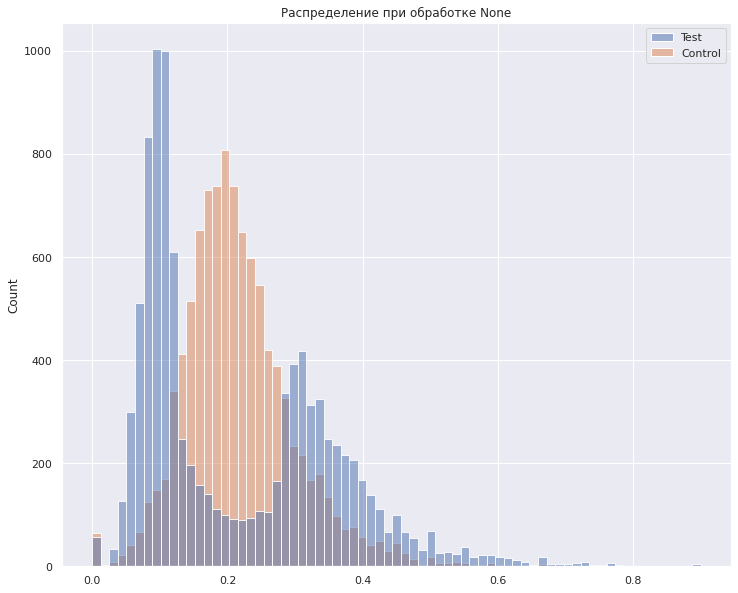

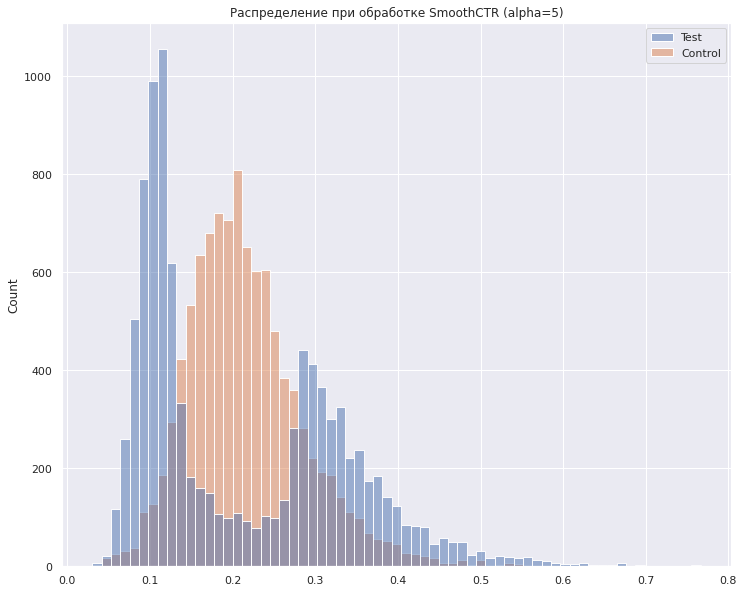

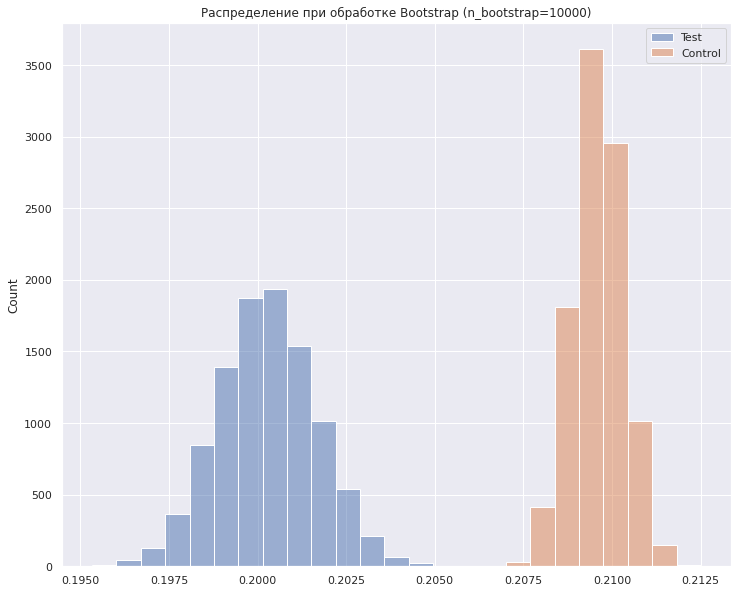

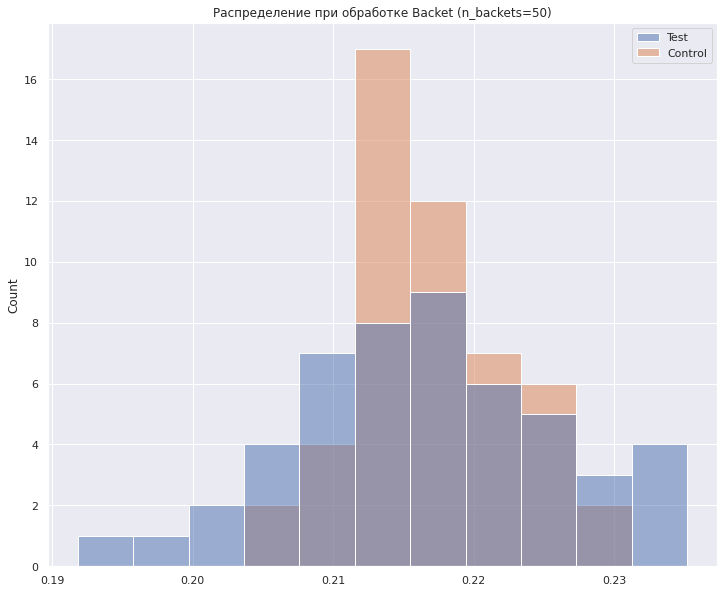

In [37]:
# Строим визуализации
test_this.view_dist_result()

1. Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).

> Классический Т-тест на таком распределения тестовой группы работает плохо. Так как распределение тестовой группы не унимодальное. 
Проблема не только, в том чтобы определить есть-ли различия, а также в какую сторону эти различия.
Когда все сложно можно сделать ставку на Бутстреп с Т-тестом.

2. Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали именно так?
> - Сырой Т-тест не нашел различий. Распределение тестовой группы далеко от нормального.
> - Манн-Уитни нашел различия, но по-прежнему не очень понятно как интерпретировать результат.
> - Т-тест поверх Пуассоновского сглаживания почти (но нет) справился но, опять-таки нет ясности интерпретации.
> - Бакетное преобразование и тесты поверх него не нашли различий между группами.
> - Бутстреп + Т-тест справился найдя различия, также сделав явным ухудшающий характер изменений в поведении тестовой группы.


3. Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.

> Тут можно предопложить ситуацию, когда новая система рекомендаций 'разломила' тестовоую группу по какому-то признаку на котором модель не училась. Например модель обучилась тому, что посты с тегом про животных имеют высокую конверсию, но не делает различий между самими животными, таким образом начинает рекомендовать вместо котиков контент про змей. Конверсия медианного пользователя падает. Также находится и специфическая группа, которым контент про змей очень нравится. Таким образом они составляют длинный хвост 'вправо', так что средний показатель CTR почти не двигается.  

4. Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

> Раскатывать НЕ будем. Есть стат. значимые изменения в худшую сторону.

______